# <center>Federated Learning & Secure Multi-Party Computation</center>

## Evaluating FL + SMPC for PrivacyBench with CNN

As a core component of the PrivacyBench framework, this implementation evaluates Federated Learning (FL) enhanced with Secure Multi-Party Computation (SMPC). This quantifies the trade-offs of privacy-preserving decentralized AI by combining FL (data privacy) with SMPC (computation privacy), serving as a critical reference for:

- Model Utility: Accuracy impact of encrypted weight aggregation.
- Computational Overhead: Training latency and memory costs from SMPC operations.
- Energy Efficiency: kWh/CO₂ emissions of secure distributed training.
  
--- 

In [1]:
%load_ext autoreload
%load_ext watermark
    
%autoreload 2
%watermark --python -p torch,flwr 

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.1.0

torch: 2.6.0
flwr : 1.18.0



--------

## Loading Dependencies

In [2]:
import os
import sys
sys.path.append("../..")

import ray
import time

import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

from logging import ERROR

from flwr.common import Context 
from flwr.client import Client, ClientApp
from flwr.client.mod import secaggplus_mod
from flwr.simulation import run_simulation

from src.config import ExperimentName
from src.paths import RAY_LOG_DIR
from src.FL_client import MedicalImageClient
from src.FL_server import weighted_average, build_evaluate_fn, build_server_app
from src.local_utility import load_yaml_config, set_device, prepare_FL_dataset

from src.tracker import reset_base_memory_csv

------

In [3]:
# Replace with appropritate values
data_name_ = "skin_lesions" #'alzheimer' #
base_type_ = "cnn"           
exp_name_ = "SMPC"
num_labels_ = 8
experiment_name_ = ExperimentName.FL_SMPC_CNN

In [4]:
DEVICE = set_device()
reset_base_memory_csv() 

fed_config = load_yaml_config(key="experiments", item_name=experiment_name_)
client_dataloaders = prepare_FL_dataset(exp_name = exp_name_, data_name=data_name_, base_type=base_type_, augment_data=True)

------

In [5]:
def client_fn(context: Context) -> Client:
    """
    Creates and initializes a federated learning client.

    This function initializes a client in the federated learning setup by 
    assigning a unique partitioned dataset and a machine learning model 
    for training and validation.

    Args:
        context (Context): The execution context containing client-specific configurations.

    Returns:
        Client: A configured federated learning client ready to participate in training.
    """
    partition_id = int(context.node_config["partition-id"]) #<--- Get the client partition ID
    
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(in_features=model.fc.in_features, out_features=num_labels_)

    # Assign partitioned client dataset
    train_loader, val_loader, test_loader = client_dataloaders[partition_id]
    
    return MedicalImageClient(model, train_loader, val_loader, exp_name=exp_name_, data_name=data_name_, base_type=base_type_, client_id=partition_id).to_client()

client = ClientApp(client_fn = client_fn, mods=[secaggplus_mod])

In [6]:
server = build_server_app(
    evaluate_fn=build_evaluate_fn(    #<--- Global evaluation function
            exp_name = exp_name_, 
            base_type = base_type_,
            data_name=data_name_, 
            experiment_item=experiment_name_, 
            num_labels=num_labels_
            ),
    metrics_fn=weighted_average,
    fed_config= fed_config,
    base_type=base_type_,
    num_labels= num_labels_
)

----- 

Set up our backend configurations before running the simulation

> - `init_args`: filter logging coming from the Simulation Engine so it's more readable in notebooks
> - `client_resources`: by default it's assumed this notebook will be ran with a compute, hence allocate to each client 2x CPU and 0.5x GPUs.

In [7]:
backend_setup = {
    "init_args": {
        "logging_level": ERROR, 
        "log_to_driver": fed_config.get("log_to_driver")
    },
    "client_resources": {
        "num_cpus": fed_config.get("num_cpus"), 
        "num_gpus": fed_config.get("num_gpus")            
    },
}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda": 
    backend_setup["client_resources"] = {"num_cpus": 2, "num_gpus": 1}

--- 

## Initiate the Simulation 

Initiate the simulation by passing the server and client apps, and specify the number of supernodes that will be selected on every round. 

2025-05-14 18:01:18,236	INFO worker.py:1771 -- Started a local Ray instance.
2025-05-14 18:01:18,264	INFO packaging.py:530 -- Creating a file package for local directory '/home/emeka/PrivacyBench'.
2025-05-14 18:01:18,283	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_44d4c629e234b78d.zip' (0.63MiB) to Ray cluster...
2025-05-14 18:01:18,287	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_44d4c629e234b78d.zip'.
05/14/2025 18:01:19:DEBUG:Asyncio event loop already running.
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
[codecarbon WARNING @ 18:01:20] Multiple instances of codecarbon are allowed to run at the same time.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=261155) is multi-threaded, use of fork() may lead to deadlocks in the child.
  se

(ClientAppActor pid=263480) 
(ClientAppActor pid=263480) 🔎 Tracker: FL + SMPC (CNN)
(ClientAppActor pid=263480) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_CNN/client_emissions.csv
(ClientAppActor pid=263480) ⏱️ Total training time: 2 minutes 47 seconds


(ClientAppActor pid=263480) /home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
(ClientAppActor pid=263480)   df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])
(ClientAppActor pid=263480) 05/14/2025 18:04:26:DEBUG:Node 8431759178770513966: starting stage 2...
(ClientAppActor pid=263480) WARNING :   Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263480) 05/14/2025 18:04:26:WARNING:Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=2634

(ClientAppActor pid=263479) 


(ClientAppActor pid=263480) Seed set to 42
(ClientAppActor pid=263480) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=263480) is multi-threaded, use of fork() may lead to deadlocks in the child. [repeated 3x across cluster]
(ClientAppActor pid=263480)   self.pid = os.fork() [repeated 3x across cluster]
(ClientAppActor pid=263479) 05/14/2025 18:04:27:DEBUG:Node 8637311656043256207: starting stage 2...
(ClientAppActor pid=263479) WARNING :   Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263479) 05/14/2025 18:04:27:WARNING:Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263479) 05/14/2025 18:04:28:DEBUG:Node 8637311656043256207: stage 2 completed, uploading masked parameters...


(ClientAppActor pid=263480) 
(ClientAppActor pid=263480) 🔎 Tracker: FL + SMPC (CNN) [repeated 2x across cluster]
(ClientAppActor pid=263480) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=263480) ⏱️ Total training time: 2 minutes 39 seconds [repeated 2x across cluster]


(ClientAppActor pid=263480) 05/14/2025 18:07:07:DEBUG:Node 6852188875448652787: starting stage 2...
(ClientAppActor pid=263480) WARNING :   Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263480) 05/14/2025 18:07:07:WARNING:Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263480) 05/14/2025 18:07:08:DEBUG:Node 6852188875448652787: stage 2 completed, uploading masked parameters...
DEBUG :     [Stage 2] Received masked vectors from 3 clients.
DEBUG :     [Stage 3] Requesting key shares from 3 clients to remove masks.
(ClientAppActor pid=263479) 05/14/2025 18:07:08:DEBUG:Node 8637311656043256207: stage 3 completes. uploading key shares...
DEBUG :     [Stage 3] Received key shares from 3 clients.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      Secure aggregation com

(ClientAppActor pid=263480) 
(ClientAppActor pid=263480) 🔎 Tracker: FL + SMPC (CNN)
(ClientAppActor pid=263480) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_CNN/client_emissions.csv
(ClientAppActor pid=263480) ⏱️ Total training time: 2 minutes 43 seconds


(ClientAppActor pid=263480) 05/14/2025 18:10:04:DEBUG:Node 8637311656043256207: starting stage 2...
(ClientAppActor pid=263480) WARNING :   Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263480) 05/14/2025 18:10:04:WARNING:Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263480) 05/14/2025 18:10:05:DEBUG:Node 8637311656043256207: stage 2 completed, uploading masked parameters...


(ClientAppActor pid=263479) 
(ClientAppActor pid=263479) 🔎 Tracker: FL + SMPC (CNN)
(ClientAppActor pid=263479) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_CNN/client_emissions.csv
(ClientAppActor pid=263479) ⏱️ Total training time: 2 minutes 44 seconds


(ClientAppActor pid=263480) Seed set to 42
(ClientAppActor pid=263480) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=263480) is multi-threaded, use of fork() may lead to deadlocks in the child. [repeated 3x across cluster]
(ClientAppActor pid=263480)   self.pid = os.fork() [repeated 3x across cluster]
(ClientAppActor pid=263479) 05/14/2025 18:10:05:DEBUG:Node 8431759178770513966: starting stage 2...
(ClientAppActor pid=263479) WARNING :   Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263479) 05/14/2025 18:10:05:WARNING:Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263479) 05/14/2025 18:10:06:DEBUG:Node 8431759178770513966: stage 2 completed, uploading masked parameters...


(ClientAppActor pid=263480) 
(ClientAppActor pid=263480) 🔎 Tracker: FL + SMPC (CNN)
(ClientAppActor pid=263480) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_CNN/client_emissions.csv
(ClientAppActor pid=263480) ⏱️ Total training time: 2 minutes 39 seconds


(ClientAppActor pid=263480) 05/14/2025 18:12:45:DEBUG:Node 6852188875448652787: starting stage 2...
(ClientAppActor pid=263480) WARNING :   Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263480) 05/14/2025 18:12:45:WARNING:Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263480) 05/14/2025 18:12:46:DEBUG:Node 6852188875448652787: stage 2 completed, uploading masked parameters...
DEBUG :     [Stage 2] Received masked vectors from 3 clients.
DEBUG :     [Stage 3] Requesting key shares from 3 clients to remove masks.
(ClientAppActor pid=263479) 05/14/2025 18:12:46:DEBUG:Node 8637311656043256207: stage 3 completes. uploading key shares...
DEBUG :     [Stage 3] Received key shares from 3 clients.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      Secure aggregation com

(ClientAppActor pid=263479) 
(ClientAppActor pid=263479) 🔎 Tracker: FL + SMPC (CNN)
(ClientAppActor pid=263479) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_CNN/client_emissions.csv
(ClientAppActor pid=263479) ⏱️ Total training time: 2 minutes 44 seconds


(ClientAppActor pid=263479) 05/14/2025 18:15:44:DEBUG:Node 8431759178770513966: starting stage 2...
(ClientAppActor pid=263479) WARNING :   Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263479) 05/14/2025 18:15:44:WARNING:Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263479) 05/14/2025 18:15:44:DEBUG:Node 8431759178770513966: stage 2 completed, uploading masked parameters...
(ClientAppActor pid=263479) Seed set to 42
(ClientAppActor pid=263479) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=263479) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=263479)   self.pid = os.fork()
(ClientAppActor pid=263479) /home/emeka/.local/share/uv/pyth

(ClientAppActor pid=263480) 
(ClientAppActor pid=263480) 🔎 Tracker: FL + SMPC (CNN)
(ClientAppActor pid=263480) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_CNN/client_emissions.csv
(ClientAppActor pid=263480) ⏱️ Total training time: 2 minutes 53 seconds


(ClientAppActor pid=263480) 05/14/2025 18:15:52:DEBUG:Node 8637311656043256207: starting stage 2...
(ClientAppActor pid=263480) WARNING :   Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263480) 05/14/2025 18:15:52:WARNING:Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263480) 05/14/2025 18:15:53:DEBUG:Node 8637311656043256207: stage 2 completed, uploading masked parameters...
(ClientAppActor pid=263479) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=263479) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=263479)   self.pid = os.fork()


(ClientAppActor pid=263479) 
(ClientAppActor pid=263479) 🔎 Tracker: FL + SMPC (CNN)
(ClientAppActor pid=263479) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_CNN/client_emissions.csv
(ClientAppActor pid=263479) ⏱️ Total training time: 2 minutes 41 seconds


(ClientAppActor pid=263479) 05/14/2025 18:18:26:DEBUG:Node 6852188875448652787: starting stage 2...
(ClientAppActor pid=263479) WARNING :   Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263479) 05/14/2025 18:18:26:WARNING:Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263479) 05/14/2025 18:18:27:DEBUG:Node 6852188875448652787: stage 2 completed, uploading masked parameters...
DEBUG :     [Stage 2] Received masked vectors from 3 clients.
DEBUG :     [Stage 3] Requesting key shares from 3 clients to remove masks.
(ClientAppActor pid=263479) 05/14/2025 18:18:28:DEBUG:Node 8431759178770513966: starting stage 3...
(ClientAppActor pid=263479) 05/14/2025 18:18:28:DEBUG:Node 8431759178770513966: stage 3 completes. uploading key shares...
(ClientAppActor pid=263479) 05/14/2025 18:18:28:DEBUG

(ClientAppActor pid=263480) 
(ClientAppActor pid=263480) 🔎 Tracker: FL + SMPC (CNN)
(ClientAppActor pid=263480) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_CNN/client_emissions.csv
(ClientAppActor pid=263480) ⏱️ Total training time: 2 minutes 44 seconds


(ClientAppActor pid=263480) 05/14/2025 18:21:25:DEBUG:Node 8431759178770513966: starting stage 2...
(ClientAppActor pid=263480) WARNING :   Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263480) 05/14/2025 18:21:25:WARNING:Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.


(ClientAppActor pid=263479) 
(ClientAppActor pid=263479) 🔎 Tracker: FL + SMPC (CNN)
(ClientAppActor pid=263479) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_CNN/client_emissions.csv
(ClientAppActor pid=263479) ⏱️ Total training time: 2 minutes 45 seconds


(ClientAppActor pid=263480) 05/14/2025 18:21:26:DEBUG:Node 8431759178770513966: stage 2 completed, uploading masked parameters...
(ClientAppActor pid=263480) Seed set to 42
(ClientAppActor pid=263480) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=263480) is multi-threaded, use of fork() may lead to deadlocks in the child. [repeated 3x across cluster]
(ClientAppActor pid=263480)   self.pid = os.fork() [repeated 3x across cluster]
(ClientAppActor pid=263479) 05/14/2025 18:21:26:DEBUG:Node 8637311656043256207: starting stage 2...
(ClientAppActor pid=263479) WARNING :   Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263479) 05/14/2025 18:21:26:WARNING:Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(C

(ClientAppActor pid=263480) 
(ClientAppActor pid=263480) 🔎 Tracker: FL + SMPC (CNN)
(ClientAppActor pid=263480) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_CNN/client_emissions.csv
(ClientAppActor pid=263480) ⏱️ Total training time: 2 minutes 48 seconds


(ClientAppActor pid=263480) 05/14/2025 18:24:15:DEBUG:Node 6852188875448652787: starting stage 2...
(ClientAppActor pid=263480) WARNING :   Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263480) 05/14/2025 18:24:15:WARNING:Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263480) 05/14/2025 18:24:16:DEBUG:Node 6852188875448652787: stage 2 completed, uploading masked parameters...
DEBUG :     [Stage 2] Received masked vectors from 3 clients.
DEBUG :     [Stage 3] Requesting key shares from 3 clients to remove masks.
(ClientAppActor pid=263479) 05/14/2025 18:24:16:DEBUG:Node 8637311656043256207: stage 3 completes. uploading key shares...
(ClientAppActor pid=263479) 05/14/2025 18:24:16:DEBUG:Node 6852188875448652787: stage 3 completes. uploading key shares...
DEBUG :     [Stage 3] Received

(ClientAppActor pid=263479) 
(ClientAppActor pid=263479) 🔎 Tracker: FL + SMPC (CNN)
(ClientAppActor pid=263479) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_CNN/client_emissions.csv
(ClientAppActor pid=263479) ⏱️ Total training time: 2 minutes 44 seconds
(ClientAppActor pid=263480) 


(ClientAppActor pid=263480) 05/14/2025 18:27:13:DEBUG:Node 8431759178770513966: starting stage 2...
(ClientAppActor pid=263480) WARNING :   Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263480) 05/14/2025 18:27:13:WARNING:Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263480) 05/14/2025 18:27:14:DEBUG:Node 8431759178770513966: stage 2 completed, uploading masked parameters...
(ClientAppActor pid=263480) Seed set to 42
(ClientAppActor pid=263480) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=263480) is multi-threaded, use of fork() may lead to deadlocks in the child. [repeated 3x across cluster]
(ClientAppActor pid=263480)   self.pid = os.fork() [repeated 3x across cluster]
(C

(ClientAppActor pid=263480) 
(ClientAppActor pid=263480) 🔎 Tracker: FL + SMPC (CNN) [repeated 2x across cluster]
(ClientAppActor pid=263480) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=263480) ⏱️ Total training time: 2 minutes 48 seconds [repeated 2x across cluster]


(ClientAppActor pid=263480) 05/14/2025 18:30:03:DEBUG:Node 6852188875448652787: starting stage 2...
(ClientAppActor pid=263480) WARNING :   Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263480) 05/14/2025 18:30:03:WARNING:Potential overflow warning: the provided weight (5703) exceeds the specified max_weight (2000). This may lead to overflow issues.
(ClientAppActor pid=263480) 05/14/2025 18:30:03:DEBUG:Node 6852188875448652787: stage 2 completed, uploading masked parameters...
DEBUG :     [Stage 2] Received masked vectors from 3 clients.
DEBUG :     [Stage 3] Requesting key shares from 3 clients to remove masks.
(ClientAppActor pid=263479) 05/14/2025 18:30:04:DEBUG:Node 8637311656043256207: stage 3 completes. uploading key shares...
(ClientAppActor pid=263479) 05/14/2025 18:30:04:DEBUG:Node 6852188875448652787: stage 3 completes. uploading key shares...
DEBUG :     [Stage 3] Received

/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=261155) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()



 ___________________________________________________________________________________________________
ExperimentName.FL_SMPC_CNN Model Final Evaluation 

Test Accuracy: 81.23% | Precision: 0.81 | Recall: 0.81 | F1-Score: 0.81 | ROC-AUC: 0.96 | MCC: 0.73
 


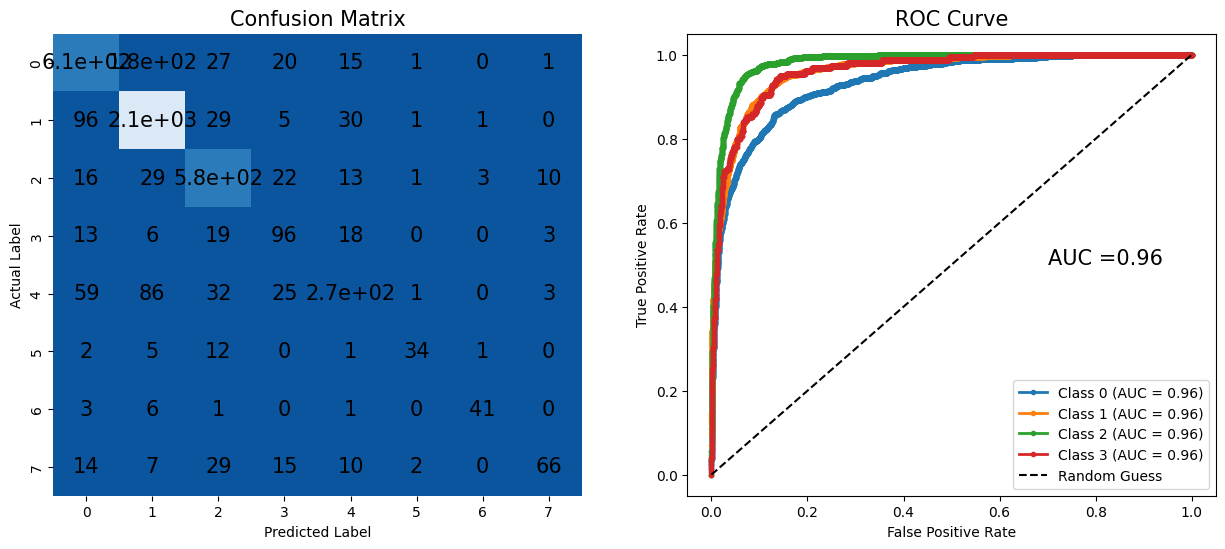


 ___________________________________________________________________________________________________
ExperimentName.FL_SMPC_CNN--skin_lesions Model Classification Report
              precision    recall  f1-score   support

           0       0.75      0.72      0.73       853
           1       0.87      0.93      0.90      2242
           2       0.80      0.86      0.83       674
           3       0.52      0.62      0.57       155
           4       0.75      0.57      0.65       476
           5       0.85      0.62      0.72        55
           6       0.89      0.79      0.84        52
           7       0.80      0.46      0.58       143

    accuracy                           0.81      4650
   macro avg       0.78      0.69      0.73      4650
weighted avg       0.81      0.81      0.81      4650

___________________________________________________________________________________________________

📊 Consolidated Metrics:
⏱️ Total Duration: 2508.79 sec
✅ Total Energy: 0.1050

Accuracy,▁
F1-Score,▁
MCC,▁
Peak FL CPU RAM (GB),▁
Peak FL GPU VRAM (GB),▁
Precision,▁
ROC-AUC,▁
Recall,▁
Total FL CO2 Emitted (kg),▁
Total FL Duration (sec),▁
Total FL Energy (kWh),▁


/home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])
INFO :      fit progress: (5, 0.7991000251614884, {'accuracy': 0.812258064516129}, 1735.582449382)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=263479) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=263479) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=263479)   self.pid = os.fork()
(ClientAppActor pid=263480) 05/14/2025 18:30:04:DEBUG:No


🕒 Total Time: 29 min 10 sec


In [8]:
project_root =  os.path.abspath("../..")

ray.shutdown()
ray.init(
    _temp_dir=str(RAY_LOG_DIR), 
    runtime_env={
        "env_vars": {
            "OMP_NUM_THREADS": "1",  #<--- Prevents thread oversubscription
            "RAY_memory_monitor_refresh_ms": "5000",
            "RAY_memory_usage_threshold": "0.85"
        },
        "working_dir": project_root,
        'excludes': ['.cache', '.venv', '.git*', '.python-version', '__pycache__', '*.pyc',
                     '*.ipynb_checkpoints', '*.ipynb', 'logs/model'], 
    },
    ignore_reinit_error=True
)

start_time = time.perf_counter()

run_simulation(
    server_app = server,
    client_app = client,
    num_supernodes = fed_config.get("num_clients"), #<-- number of clients
    backend_config=backend_setup
)

end_time = time.perf_counter()
duration = end_time - start_time
print(f"\n🕒 Total Time: {duration // 60:.0f} min {duration % 60:.0f} sec")

ray.shutdown()

-----